# Base Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [3]:
# load normalized data
path_years_norm = "/content/drive/MyDrive/FinalProject/sPINN/data/df_years_norm.csv"
path_days_norm  = "/content/drive/MyDrive/FinalProject/sPINN/data/df_days_norm.csv"

df_years_norm = pd.read_csv(path_years_norm)
df_days_norm  = pd.read_csv(path_days_norm)

In [4]:
# make sliding window dataset
def make_sliding_window(df, window_size, steps_ahead, target_col):
    # get features (everything except target)
    feature_cols = [c for c in df.columns if c != target_col]
    features = df[feature_cols].values.astype(float)

    # target values
    y_full = df[target_col].values.astype(float)

    X_list = []
    y_list = []

    # build sliding windows
    for i in range(len(features) - window_size - steps_ahead):
        window = features[i:i+window_size]
        target = y_full[i + window_size + steps_ahead]

        X_list.append(window)
        y_list.append(target)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y


In [5]:
# years sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_years, y_years = make_sliding_window(
    df_years_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [6]:
# days sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_days, y_days = make_sliding_window(
    df_days_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [7]:
# plot the first window of a dataset
def plot_first_window(df, window_size, title_name):
    # get feature cols
    feature_cols = [c for c in df.columns]
    features = df[feature_cols].values.astype(float)

    # first window
    first_window = features[:window_size]

    # flip for plotting
    first_window_flipped = first_window.T

    # plot window
    plt.figure(figsize=(10, 6))
    plt.imshow(first_window_flipped, aspect="auto", cmap="viridis")
    plt.title(f"{title_name} Window ({first_window_flipped.shape[0]} features × {first_window_flipped.shape[1]} time steps)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.colorbar()
    plt.show()


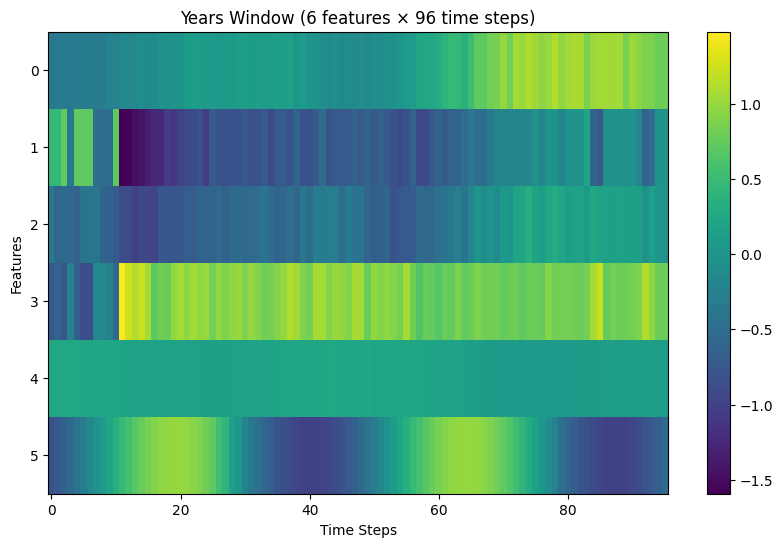

In [8]:
plot_first_window(df_years_norm, window_size=96, title_name="Years")

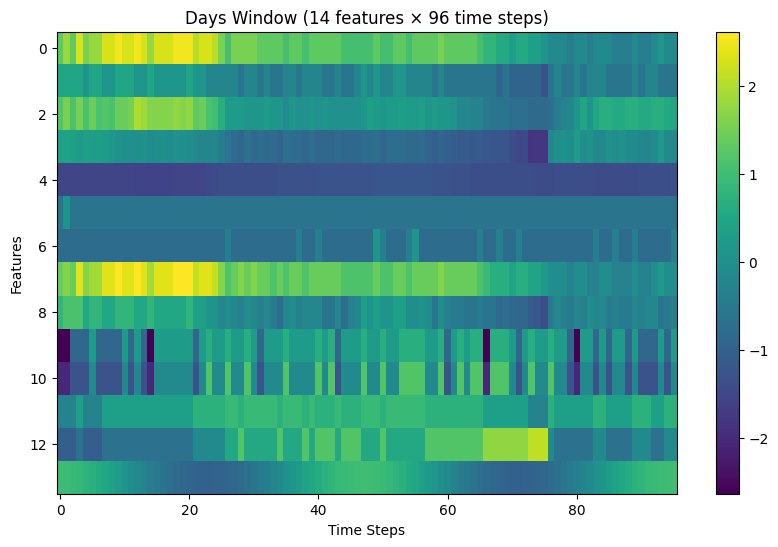

In [9]:
plot_first_window(df_days_norm, window_size=96, title_name="Days")


# CNN

In [10]:
# reshape for CNN (N, 1, window_size, num_features)
X_years_cnn = X_years.reshape(X_years.shape[0], 1, X_years.shape[1], X_years.shape[2])
X_days_cnn  = X_days.reshape(X_days.shape[0],  1, X_days.shape[1],  X_days.shape[2])

In [11]:
from sklearn.model_selection import train_test_split

# YEARS
X_train_years, X_val_years, y_train_years, y_val_years = train_test_split(
    X_years_cnn, y_years, test_size=0.2, shuffle=False
)

# DAYS
X_train_days, X_val_days, y_train_days, y_val_days = train_test_split(
    X_days_cnn, y_days, test_size=0.2, shuffle=False
)

In [12]:
# YEARS
X_train_years_t = torch.tensor(X_train_years, dtype=torch.float32)
y_train_years_t = torch.tensor(y_train_years, dtype=torch.float32).view(-1, 1)

X_val_years_t = torch.tensor(X_val_years, dtype=torch.float32)
y_val_years_t = torch.tensor(y_val_years, dtype=torch.float32).view(-1, 1)

# DAYS
X_train_days_t = torch.tensor(X_train_days, dtype=torch.float32)
y_train_days_t = torch.tensor(y_train_days, dtype=torch.float32).view(-1, 1)

X_val_days_t = torch.tensor(X_val_days, dtype=torch.float32)
y_val_days_t = torch.tensor(y_val_days, dtype=torch.float32).view(-1, 1)

In [26]:
class WaveCNN(nn.Module):
    def __init__(self, window_size, num_features):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # auto-detect flatten size for THIS dataset
        with torch.no_grad():
            dummy = torch.zeros(1, 1, window_size, num_features)
            flat_dim = self.conv(dummy).numel()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [27]:
num_features_years = X_years.shape[2]
model_years = WaveCNN(window_size=12, num_features=num_features_years)

num_features_days = X_days.shape[2]
model_days = WaveCNN(window_size=12, num_features=num_features_days)

In [28]:
optimizer_years = torch.optim.Adam(model_years.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses_years = []
val_losses_years = []

epochs = 250

for epoch in range(epochs):
    # TRAIN
    model_years.train()
    optimizer_years.zero_grad()
    pred = model_years(X_train_years_t)
    loss = loss_fn(pred, y_train_years_t)
    loss.backward()
    optimizer_years.step()

    # VAL
    model_years.eval()
    with torch.no_grad():
        val_pred = model_years(X_val_years_t)
        val_loss = loss_fn(val_pred, y_val_years_t)

    train_losses_years.append(loss.item())
    val_losses_years.append(val_loss.item())

    if epoch % 25 == 0:
        print(f"[YEARS CNN] Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

[YEARS CNN] Epoch 0: train=1.2002, val=0.4227
[YEARS CNN] Epoch 25: train=1.2019, val=0.2123
[YEARS CNN] Epoch 50: train=1.1945, val=0.2090
[YEARS CNN] Epoch 75: train=1.1866, val=0.2105
[YEARS CNN] Epoch 100: train=1.1734, val=0.2130
[YEARS CNN] Epoch 125: train=1.1441, val=0.2203
[YEARS CNN] Epoch 150: train=1.0840, val=0.2297
[YEARS CNN] Epoch 175: train=0.9858, val=0.2429
[YEARS CNN] Epoch 200: train=0.8753, val=0.2681
[YEARS CNN] Epoch 225: train=0.7922, val=0.2700


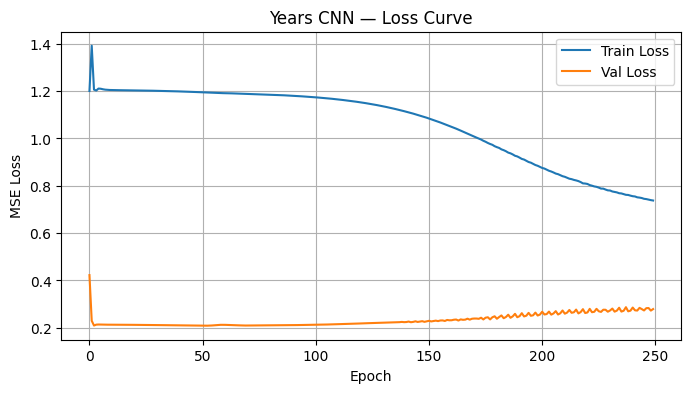

In [29]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_years, label="Train Loss")
plt.plot(val_losses_years,   label="Val Loss")
plt.title("Years CNN — Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
optimizer_days = torch.optim.Adam(model_days.parameters(), lr=1e-3)

train_losses_days = []
val_losses_days = []

for epoch in range(epochs):
    # TRAIN
    model_days.train()
    optimizer_days.zero_grad()
    pred = model_days(X_train_days_t)
    loss = loss_fn(pred, y_train_days_t)
    loss.backward()
    optimizer_days.step()

    # VAL
    model_days.eval()
    with torch.no_grad():
        val_pred = model_days(X_val_days_t)
        val_loss = loss_fn(val_pred, y_val_days_t)

    train_losses_days.append(loss.item())
    val_losses_days.append(val_loss.item())

    if epoch % 25 == 0:
        print(f"[DAYS CNN] Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

[DAYS CNN] Epoch 0: train=1.1442, val=0.8996
[DAYS CNN] Epoch 25: train=0.1994, val=5.0980
[DAYS CNN] Epoch 50: train=0.0905, val=7.2513
[DAYS CNN] Epoch 75: train=0.0378, val=7.8614
[DAYS CNN] Epoch 100: train=0.0178, val=8.1839
[DAYS CNN] Epoch 125: train=0.0242, val=8.5767
[DAYS CNN] Epoch 150: train=0.0078, val=8.2612
[DAYS CNN] Epoch 175: train=0.0053, val=8.5704
[DAYS CNN] Epoch 200: train=0.0040, val=8.7070
[DAYS CNN] Epoch 225: train=0.0031, val=8.7489


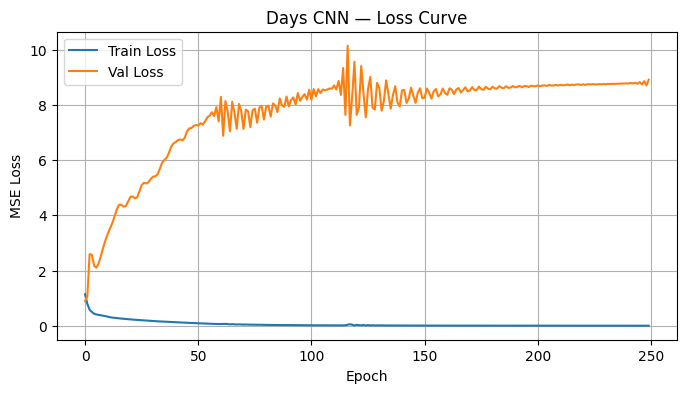

In [31]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_days, label="Train Loss")
plt.plot(val_losses_days,   label="Val Loss")
plt.title("Days CNN — Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
model_years.eval()
model_days.eval()

with torch.no_grad():
    pred_years = model_years(X_val_years_t).cpu().numpy().flatten()
    pred_days  = model_days(X_val_days_t).cpu().numpy().flatten()
    real_years = y_val_years_t.cpu().numpy().flatten()
    real_days  = y_val_days_t.cpu().numpy().flatten()

In [33]:
plot_len = 336  # 7 days * 48 samples/day

real_7       = real_days[:plot_len]
pred_days_7  = pred_days[:plot_len]
pred_years_7 = pred_years[:plot_len]

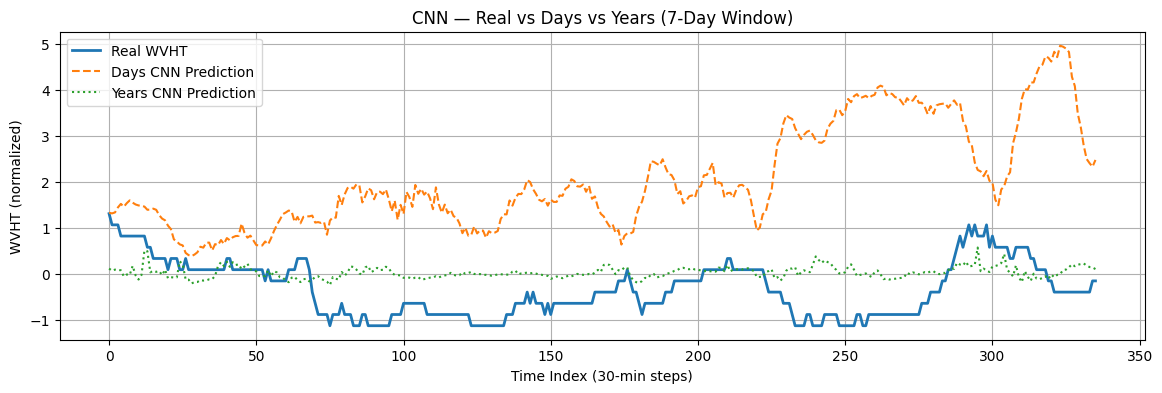

In [34]:
plt.figure(figsize=(14,4))

plt.plot(real_7,       label="Real WVHT", linewidth=2)
plt.plot(pred_days_7,  label="Days CNN Prediction", linestyle="--")
plt.plot(pred_years_7, label="Years CNN Prediction", linestyle=":")

plt.title("CNN — Real vs Days vs Years (7-Day Window)")
plt.xlabel("Time Index (30-min steps)")
plt.ylabel("WVHT (normalized)")
plt.grid(True)
plt.legend()
plt.show()